In [1]:
%matplotlib inline


Neural Networks
===============

Neural networks can be constructed using the ``torch.nn`` package.

It is a simple feed-forward network. It takes the input, feeds it
through several layers one after the other, and then finally gives the
output.

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:


In [2]:
import glob
import numpy as np
import os
import os.path as path
from scipy import misc
from scipy.misc import imread
import PIL
from PIL import Image
import cv2
import matplotlib
import numpy as np
from matplotlib.pyplot import ginput, imshow, imread, show
import matplotlib.pyplot as plt
#%matplotlib auto
#%matplotlib inline

In [3]:
import os
#Python list directory, subdirectory, and files
new_files=[val for sublist in [[os.path.join(i[0], j) for j in i[2]] for i in os.walk('./Data')] for val in sublist]
new_files = new_files[1:]
print(len(new_files))

230


In [4]:
import os
import pickle
import torch

file = open('coords_500', 'rb')

# dump information to that file
coords = pickle.load(file)

# close the file
file.close()

all_points = []
all_images = []
imsize = 500
for item in coords:
    point = torch.tensor(item[0])
    filename = item[1]
    im = matplotlib.pyplot.imread(filename)
    #print(np.shape(im))
    im = cv2.resize(im, (imsize, imsize)) #.mean(dim=2)
    
    #print(im_size)
    im = torch.tensor(im).mean(dim=2)
    

    all_points.append(point)
    all_images.append(im)


161
161


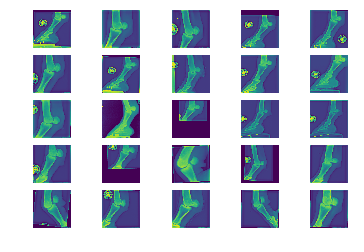

In [5]:
# split the dataset to the training set and test set

split_1 = int(0.7 * len(new_files))
print(split_1)
train_images = all_images[:split_1]
train_points = all_points[:split_1]
print(len(train_images))
    
i_ = 0
for ima in train_images:
    plt.subplot(5, 5, i_+1) 
    plt.imshow(ima); plt.axis('off')
    i_ += 1
    
    if i_ >24:
        break


69
69
69


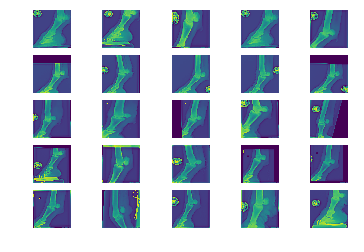

In [6]:
# test set

split_2 = int(0.3 * len(new_files))
print(split_2)
test_images = all_images[split_1:]
print(len(test_images))
test_points = all_points[split_1:]
print(len(test_images))
    
i_ = 0
for imb in test_images:
    plt.subplot(5, 5, i_+1) 
    plt.imshow(imb); plt.axis('off')
    i_ += 1
    
    if i_ >24:
        break


Define the network
------------------

Let’s define this network:

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        
        #self.filtersize = 5
    
        #self.conv1 = nn.Conv2d(1, 6, self.filtersize)
        #conv1_size = (imsize - self.filtersize + 1) / 2
        #print(conv1_size)
        #self.conv2 = nn.Conv2d(6, 16, self.filtersize)
        #conv2_size = (conv1_size - self.filtersize + 1) / 2
        #print(conv2_size)
        #print(16 * conv2_size * conv2_size)
        # an affine operation: y = Wx + b
        #self.fc1 = nn.Linear(int(16 * conv2_size * conv2_size), 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 2)
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 122 * 122, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=238144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [8]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


In [9]:
import torch.optim as optim
import pickle

# create optimizer
#optimizer = optim.SGD(net.parameters(), lr=0.0001)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
for input, target in zip(train_images, train_points):
    print("Target:")
    print(target)
    
    input = input.reshape(1,1,imsize, imsize)
    net.zero_grad()
    output = net(input)
    print("Output:")
    print(output)
                          
    
    criterion = nn.MSELoss()
    loss = criterion(output, target)
    print("Loss:")
    print(loss)

    
    
    #print(loss.grad_fn)  # MSELoss
    #print(loss.grad_fn.next_functions[0][0])  # Linear
    #print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

    
    
    
    # Backprop
    #net.zero_grad()     # zeroes the gradient buffers of all parameters

    #print('conv1.bias.grad before backward')
    #print(net.conv1.bias.grad)

    loss.backward()
    optimizer.step()
    #print('conv1.bias.grad after backward')
    #print(net.conv1.bias.grad)
    
    
    

Target:
tensor([[335.9606,  90.1917]])
Output:
tensor([[-0.0939, -0.0264]], grad_fn=<AddmmBackward>)
Loss:
tensor(60535.9844, grad_fn=<MseLossBackward>)
Target:
tensor([[200.2910, 207.4654]])
Output:
tensor([[0.3882, 0.0887]], grad_fn=<AddmmBackward>)
Loss:
tensor(41483.1289, grad_fn=<MseLossBackward>)
Target:
tensor([[225.5854, 281.0489]])
Output:
tensor([[0.9062, 0.3410]], grad_fn=<AddmmBackward>)
Loss:
tensor(64638.8203, grad_fn=<MseLossBackward>)
Target:
tensor([[322.1637, 177.5721]])
Output:
tensor([[1.2948, 0.7575]], grad_fn=<AddmmBackward>)
Loss:
tensor(67110.1484, grad_fn=<MseLossBackward>)
Target:
tensor([[322.1637, 110.8870]])
Output:
tensor([[1.8326, 1.1545]], grad_fn=<AddmmBackward>)
Loss:
tensor(57326.6445, grad_fn=<MseLossBackward>)
Target:
tensor([[230.1843, 166.0747]])
Output:
tensor([[2.4270, 1.4838]], grad_fn=<AddmmBackward>)
Loss:
tensor(39481.7930, grad_fn=<MseLossBackward>)
Target:
tensor([[352.0570, 126.9834]])
Output:
tensor([[3.4393, 1.9925]], grad_fn=<AddmmBack

Target:
tensor([[237.0828, 186.7701]])
Output:
tensor([[229.9870, 149.9298]], grad_fn=<AddmmBackward>)
Loss:
tensor(703.7776, grad_fn=<MseLossBackward>)
Target:
tensor([[289.9709, 172.9731]])
Output:
tensor([[237.1427, 154.0097]], grad_fn=<AddmmBackward>)
Loss:
tensor(1575.2206, grad_fn=<MseLossBackward>)
Target:
tensor([[414.1431,  41.9025]])
Output:
tensor([[269.9359, 175.0387]], grad_fn=<AddmmBackward>)
Loss:
tensor(19260.4902, grad_fn=<MseLossBackward>)
Target:
tensor([[301.4684, 237.3587]])
Output:
tensor([[248.9112, 159.9361]], grad_fn=<AddmmBackward>)
Loss:
tensor(4378.2563, grad_fn=<MseLossBackward>)
Target:
tensor([[342.8591, 101.6891]])
Output:
tensor([[290.2153, 184.9711]], grad_fn=<AddmmBackward>)
Loss:
tensor(4853.6353, grad_fn=<MseLossBackward>)
Target:
tensor([[276.1740, 117.7855]])
Output:
tensor([[284.8947, 180.0227]], grad_fn=<AddmmBackward>)
Loss:
tensor(1974.7576, grad_fn=<MseLossBackward>)
Target:
tensor([[273.8745, 248.8561]])
Output:
tensor([[274.4953, 171.3706]]

Loss:
tensor(3064.1426, grad_fn=<MseLossBackward>)
Target:
tensor([[154.3013, 221.2623]])
Output:
tensor([[249.3490, 192.6867]], grad_fn=<AddmmBackward>)
Loss:
tensor(4925.3101, grad_fn=<MseLossBackward>)
Target:
tensor([[248.5802, 145.3793]])
Output:
tensor([[293.4847, 227.3022]], grad_fn=<AddmmBackward>)
Loss:
tensor(4363.8843, grad_fn=<MseLossBackward>)
Target:
tensor([[384.2498, 108.5876]])
Output:
tensor([[303.0301, 229.7431]], grad_fn=<AddmmBackward>)
Loss:
tensor(10637.6611, grad_fn=<MseLossBackward>)
Target:
tensor([[174.9967, 186.7701]])
Output:
tensor([[251.5842, 194.3071]], grad_fn=<AddmmBackward>)
Loss:
tensor(2961.2271, grad_fn=<MseLossBackward>)
Target:
tensor([[202.5905, 216.6634]])
Output:
tensor([[257.0269, 197.6498]], grad_fn=<AddmmBackward>)
Loss:
tensor(1662.4154, grad_fn=<MseLossBackward>)
Target:
tensor([[195.6920, 212.0644]])
Output:
tensor([[259.6151, 199.1191]], grad_fn=<AddmmBackward>)
Loss:
tensor(2126.8716, grad_fn=<MseLossBackward>)
Target:
tensor([[230.184

In [10]:
for test_input, test_target in zip(test_images, test_points):
    print("Test_Target:")
    print(test_target)
    
    test_input = test_input.reshape(1,1,imsize, imsize)
    net.zero_grad()
    test_output = net(test_input)
    print("Test_Output:")
    print(test_output)
                          
    
    criterion = nn.MSELoss()
    test_loss = criterion(test_output, test_target)
    print("Test_Loss:")
    print(test_loss)


Test_Target:
tensor([[358.9555,  99.3896]])
Test_Output:
tensor([[273.2523, 177.0923]], grad_fn=<AddmmBackward>)
Test_Loss:
tensor(6691.3682, grad_fn=<MseLossBackward>)
Test_Target:
tensor([[345.1586,  28.1056]])
Test_Output:
tensor([[300.1649, 196.1645]], grad_fn=<AddmmBackward>)
Test_Loss:
tensor(15134.1133, grad_fn=<MseLossBackward>)
Test_Target:
tensor([[241.6817,  87.8922]])
Test_Output:
tensor([[272.3955, 183.9471]], grad_fn=<AddmmBackward>)
Test_Loss:
tensor(5084.9370, grad_fn=<MseLossBackward>)
Test_Target:
tensor([[354.3565,  94.7907]])
Test_Output:
tensor([[273.2523, 177.0923]], grad_fn=<AddmmBackward>)
Test_Loss:
tensor(6675.7246, grad_fn=<MseLossBackward>)
Test_Target:
tensor([[218.6869, 276.4500]])
Test_Output:
tensor([[256.0305, 171.8403]], grad_fn=<AddmmBackward>)
Test_Loss:
tensor(6168.8647, grad_fn=<MseLossBackward>)
Test_Target:
tensor([[322.1637, 239.6582]])
Test_Output:
tensor([[231.5653, 152.3038]], grad_fn=<AddmmBackward>)
Test_Loss:
tensor(7919.4380, grad_fn=<Mse

Test_Output:
tensor([[226.8109, 150.2763]], grad_fn=<AddmmBackward>)
Test_Loss:
tensor(1919.1362, grad_fn=<MseLossBackward>)
Test_Target:
tensor([[340.5596,  92.4912]])
Test_Output:
tensor([[277.4842, 181.0876]], grad_fn=<AddmmBackward>)
Test_Loss:
tensor(5913.9185, grad_fn=<MseLossBackward>)
Test_Target:
tensor([[218.6869, 287.9474]])
Test_Output:
tensor([[239.1509, 160.7162]], grad_fn=<AddmmBackward>)
Test_Loss:
tensor(8303.2754, grad_fn=<MseLossBackward>)
Test_Target:
tensor([[276.1740, 239.6582]])
Test_Output:
tensor([[235.3104, 157.4242]], grad_fn=<AddmmBackward>)
Test_Loss:
tensor(4216.1343, grad_fn=<MseLossBackward>)
Test_Target:
tensor([[262.3771, 271.8510]])
Test_Output:
tensor([[226.0954, 149.8564]], grad_fn=<AddmmBackward>)
Test_Loss:
tensor(8099.5137, grad_fn=<MseLossBackward>)
Test_Target:
tensor([[319.8642, 122.3845]])
Test_Output:
tensor([[253.3840, 164.9351]], grad_fn=<AddmmBackward>)
Test_Loss:
tensor(3115.0881, grad_fn=<MseLossBackward>)
Test_Target:
tensor([[283.0725

In [ ]:
num_epochs = 1000
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(num_epochs):
    #for input in train_images:
    for input, target in zip(train_images, train_points):
        input = input.reshape(1,1,imsize, imsize)
        steps += 1
        optimizer.zero_grad()
        output = net(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
           
            
            with torch.no_grad():
                #for test_input in test_images:
                for test_input, test_target in zip(test_images, test_points):
                    test_input = test_input.reshape(1,1,imsize, imsize)
                    test_output = net(test_input)
                    batch_loss = criterion(test_output, test_target)
                    test_loss += batch_loss.item()

            train_losses.append(running_loss/len(input))
            #print(train_losses)
            test_losses.append(test_loss/len(test_input))
            #print(test_losses)
            print(f"Epoch {epoch+1}/{num_epochs}.. "
                    f"Train loss: {running_loss/print_every:.3f}.. "
                    f"Test loss: {test_loss/len(test_input):.3f}.. ")
            
            
            print(f"Epoch {epoch+1}/{num_epochs}.. "
                    f"Train loss: {running_loss/print_every:.3f}.. ")
            running_loss = 0
            net.train()
torch.save(net, 'aerialmodel.pth')

Epoch 1/1000.. Train loss: 3470.739.. Test loss: 325076.880.. 
Epoch 1/1000.. Train loss: 3470.739.. 
Epoch 1/1000.. Train loss: 4446.173.. Test loss: 340354.634.. 
Epoch 1/1000.. Train loss: 4446.173.. 
Epoch 1/1000.. Train loss: 4143.811.. Test loss: 368402.344.. 
Epoch 1/1000.. Train loss: 4143.811.. 
Epoch 1/1000.. Train loss: 2830.924.. Test loss: 317810.902.. 
Epoch 1/1000.. Train loss: 2830.924.. 
Epoch 1/1000.. Train loss: 3207.499.. Test loss: 316701.455.. 
Epoch 1/1000.. Train loss: 3207.499.. 
Epoch 1/1000.. Train loss: 3058.481.. Test loss: 324763.573.. 
Epoch 1/1000.. Train loss: 3058.481.. 
Epoch 1/1000.. Train loss: 3207.826.. Test loss: 336892.152.. 
Epoch 1/1000.. Train loss: 3207.826.. 
Epoch 1/1000.. Train loss: 4278.125.. Test loss: 302591.287.. 
Epoch 1/1000.. Train loss: 4278.125.. 
Epoch 1/1000.. Train loss: 4030.050.. Test loss: 295947.384.. 
Epoch 1/1000.. Train loss: 4030.050.. 
Epoch 1/1000.. Train loss: 4871.056.. Test loss: 289422.105.. 
Epoch 1/1000.. Trai

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
#plt.xlim(0,10)
#plt.ylim(0,10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

# Finished Training.

# Coordinates

In [144]:
import pickle

# open a file, where you stored the pickled data
file = open('coords_500', 'rb')

# dump information to that file
coords = pickle.load(file)

# close the file
file.close()

print('Showing the pickled data:', '[[(x,y)],', 'Name of image]')

cnt = 0
for item in coords:
    print('The coords ', cnt, ' is : ', item)
    cnt += 1

Showing the pickled data: [[(x,y)], Name of image]
The coords  0  is :  [[(335.96063281824865, 90.19168506254607)], './size500/Data/S614500/S614500_LF not perfect_0001.png']
The coords  1  is :  [[(200.29102281089035, 207.46541574687274)], './size500/Data/S614500/S614500_RH cropped perfect_0001.png']
The coords  2  is :  [[(225.58535688005884, 281.04893303899934)], './size500/Data/S614500/S614500_RF cropped perfect_0001.png']
The coords  3  is :  [[(322.16372332597496, 177.57211184694637)], './size500/Data/S614500/S614500_LH perfect_0001.png']
The coords  4  is :  [[(322.16372332597496, 110.88704930095668)], './size500/Data/S614500/S614500_RH not perfect_0001.png']
The coords  5  is :  [[(230.18432671081672, 166.07468727005158)], './size500/Data/S614500/S614500_LF cropped perfect_0001.png']
The coords  6  is :  [[(352.0570272259014, 126.98344370860934)], './size500/Data/S614500/S614500_RF not perfect_0001.png']
The coords  7  is :  [[(273.8745401030169, 200.5669610007359)], './size500/

In [145]:
print(len(coords))
print(coords[2][0][0])
x,y=coords[2][0][0]
print(x,y)
print(x)
print(y)

230
(225.58535688005884, 281.04893303899934)
225.58535688005884 281.04893303899934
225.58535688005884
281.04893303899934


In [ ]:
import cv2
x=[]
y=[]
img=[]
delta = 25
for item in coords:
    #x1,y1=item[0][0]
    x1,y1=coords[item][0][0] 
    #print('(', x1,',', y1, ')')
    print(x1)
    print(y1)
    #print(len(coords))
    pixels = [x1-delta: x1+delta]*[y1-delta: y1+delta]
    print(pixels)
    filename = item[1]
    im = matplotlib.pyplot.imread(filename)
    cv2.rectangle(im, (x1,y1),([x1-delta: x1+delta], [y1-delta: y1+delta]) , (0,0,225), 2)
    extracted_im = im[y1:[y1-delta: y1+delta], x1:[x1-delta: x1+delta]]
    cv2.imshow("Extracted", extracted_im)
    x.append(x1)
    y.append(y1)
    img.append(im)
    

In [146]:
x=[]
y=[]

for i in range(229):
    x1,y1=coords[i][0][0]
    x.append(x1)
    y.append(y1) 
    print('(', x1,',', y1, ')')
    #print(x1)
    #print(y1)
    #print(len(coords))
    
    
    sum_square_error = 0.0
    for j in range(len(coords)):
        sum_square_error += (x1 - y1)**2.0
        #print(sum_square_error)
    mean_square_error = 1.0 / 230 * sum_square_error
    print(mean_square_error)
print(len(x),len(y))

( 335.96063281824865 , 90.19168506254607 )
60402.375680945384
( 200.29102281089035 , 207.46541574687274 )
51.471913999874104
( 225.58535688005884 , 281.04893303899934 )
3076.2082803385892
( 322.16372332597496 , 177.57211184694637 )
20906.73411010238
( 322.16372332597496 , 110.88704930095668 )
44637.832987073816
( 230.18432671081672 , 166.07468727005158 )
4110.045869224929
( 352.0570272259014 , 126.98344370860934 )
50658.11799731533
( 273.8745401030169 , 200.5669610007359 )
5374.00115383719
( 303.7678440029433 , 97.09013980868292 )
42715.67341101002
( 372.7523914643119 , 51.100441501103774 )
103459.97691513467
( 202.59050772626927 , 258.05408388520976 )
3076.2082803385892
( 349.75754231052235 , 115.48601913171456 )
54883.14657251894
( 262.3771155261221 , 87.8922001471671 )
30444.98569480121
( 273.8745401030169 , 145.37932303164098 )
16511.020810219954
( 301.4683590875643 , 143.079838116262 )
25086.923575476725
( 260.0776306107432 , 106.28807947019874 )
23651.226040010257
( 315.265268579